<a href="https://colab.research.google.com/github/CalculatedContent/WW_PGD/blob/main/WW_PGD_QuickStart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/CalculatedContent/WW_PGD

fatal: destination path 'WW_PGD' already exists and is not an empty directory.


In [2]:
import sys
!{sys.executable} -m pip uninstall -y ww_pgd
!{sys.executable} -m pip install -e /content/WW_PGD

Obtaining file:///content/WW_PGD
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for ww_pgd (pyproject.toml) ... done
  Created wheel for ww_pgd: filename=ww_pgd-0.1.0-0.editable-py3-none-any.whl size=4214 sha256=6ca099935132a5c59cb27f15e09dd6f264359cdfc3803aa58ca2278632b2c350
  Stored in directory: /tmp/pip-ephem-wheel-cache-l50owbnp/wheels/3b/3c/33/0d2a4467bbe2ae0dfe63d9943a304711b73f2ba07b2dc4f5e4
Successfully built ww_pgd


In [ ]:
#restart Google colab session first

import os, signal
os.kill(os.getpid(), signal.SIGKILL)


In [1]:
import ww_pgd
print("Imported from:", ww_pgd.__file__)

Imported from: /content/WW_PGD/ww_pgd/__init__.py


# QuickStart (trivial example)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import ww_pgd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Data loader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_ds = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
loader = DataLoader(train_ds, batch_size=128, shuffle=True)

# Model
model = nn.Linear(28 * 28, 10).to(device)

# Optimizers
base_opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
cfg = ww_pgd.WWTailConfig(warmup_epochs=0, ramp_epochs=5)
opt = ww_pgd.WWPGDWrapper(model, base_opt, cfg)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        xb = xb.view(xb.size(0), -1)  # flatten

        loss = F.cross_entropy(model(xb), yb)
        opt.zero_grad(set_to_none=True);
        loss.backward()
        opt.step()

    # epoch-boundary spectral projection
    opt.apply_tail_projection(epoch=epoch, num_epochs=num_epochs)
    print(f"epoch {epoch+1}/{num_epochs} done")

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 189kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.48MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 22.7MB/s]


SMALL N PL FIT
epoch 1/10 done
SMALL N PL FIT
epoch 2/10 done
SMALL N PL FIT
epoch 3/10 done
SMALL N PL FIT
epoch 4/10 done
SMALL N PL FIT
epoch 5/10 done
SMALL N PL FIT
epoch 6/10 done
SMALL N PL FIT
epoch 7/10 done
SMALL N PL FIT
epoch 8/10 done
SMALL N PL FIT
epoch 9/10 done
SMALL N PL FIT
epoch 10/10 done


SMALL N PL FIT


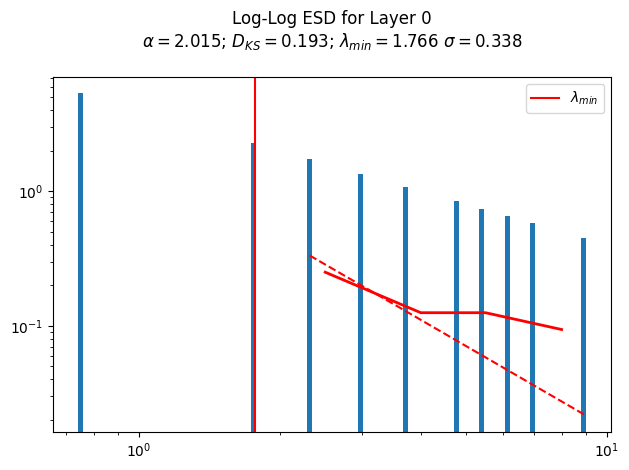

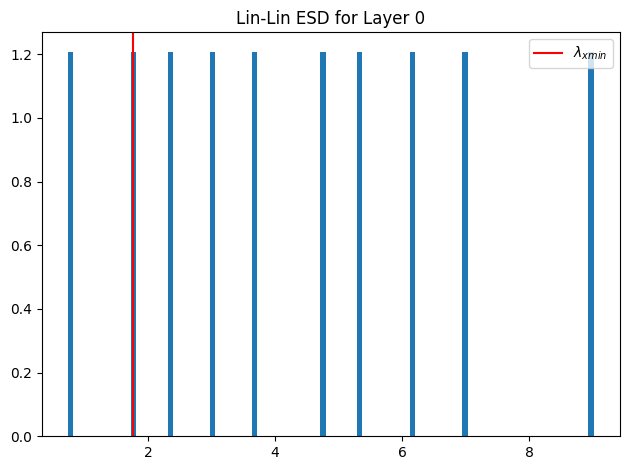

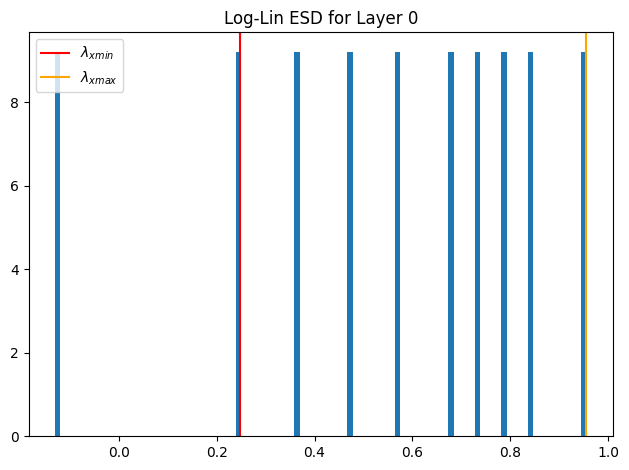

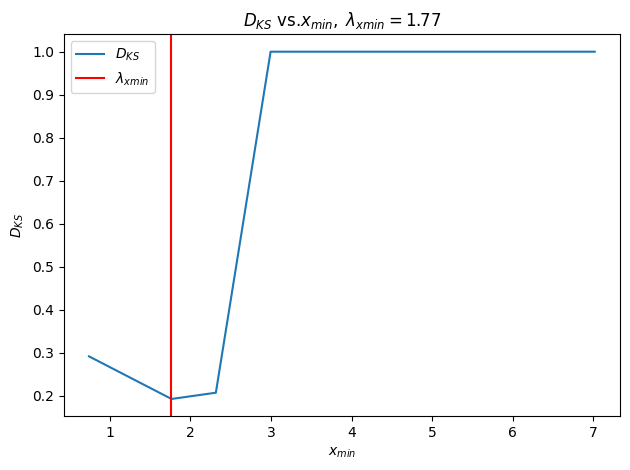

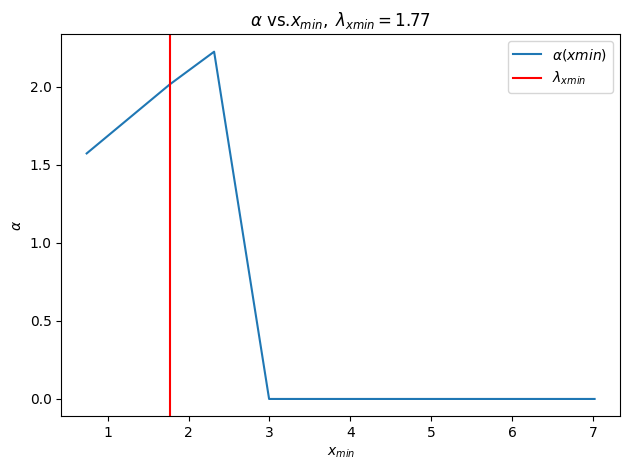

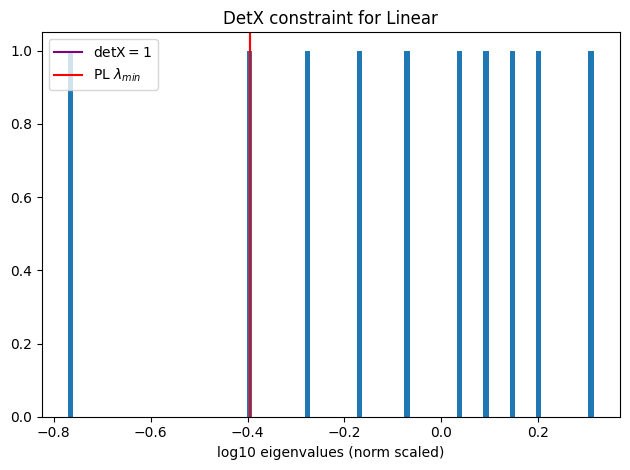

,layer_id,name,D,M,N,Q,alpha,alpha_weighted,detX_num,detX_val,...,sigma,spectral_norm,stable_rank,status,sv_max,sv_min,warning,weak_rank_loss,xmax,xmin
0,0,Linear,0.192956,10,784,78.4,2.015195,1.924828,9,1.76565,...,0.338398,9.018971,4.849055,success,3.00316,0.861308,,0,9.018971,1.76565


<Figure size 640x480 with 0 Axes>

In [3]:
import weightwatcher as ww
watcher = ww.WeightWatcher(model=model)
details = watcher.analyze(detX=True, randomize=False, plot=True)
details

# Real Test: Train a 3-layer MLP on FashionMNIST

In [ ]:
# ======================================================
# COMPLETE WORKING COLAB CELL (MNIST)
# 5x Baseline vs 5x ww_pgd on MNIST (35 epochs)
# Logs + plots: plain-test AND augmented-test accuracy per epoch
# Plus WW metric plots (alpha/xmin/detX_num + detX_num - num_pl_spikes)
# ======================================================

# If you're using a local editable install already, you can comment these out.
!pip -q install weightwatcher
# If ww_pgd is not installed in your Colab kernel yet, uncomment:
# !pip -q install git+https://github.com/CalculatedContent/WW_PGD.git

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import List

import weightwatcher as ww
import ww_pgd

# -----------------------------
# Global experiment config
# -----------------------------
NUM_EPOCHS = 35
N_RUNS = 5

# -----------------------------
# Device
# -----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

pin_memory = device == "cuda"
num_workers = 2

# -----------------------------
# MNIST dataset + DataLoaders
# -----------------------------
batch_size = 128

plain_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_ds = datasets.MNIST(root="./data", train=True,  download=True, transform=plain_transform)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=plain_transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=pin_memory)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=pin_memory)

# Augmented evaluation transform (mild, in-distribution for MNIST)
# NOTE: No horizontal flip for digits.
aug_eval_transform = transforms.Compose([
    transforms.RandomRotation(7),
    transforms.RandomAffine(degrees=0, translate=(0.03, 0.03)),
    transforms.GaussianBlur(3, sigma=(0.1, 0.3)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_aug_ds = datasets.MNIST(root="./data", train=False, download=True, transform=aug_eval_transform)
test_aug_loader = DataLoader(test_aug_ds, batch_size=batch_size, shuffle=False,
                             num_workers=num_workers, pin_memory=pin_memory)

# -----------------------------
# Evaluation
# -----------------------------
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = F.cross_entropy(logits, yb, reduction="sum")
        total_loss += loss.item()
        preds = logits.argmax(dim=-1)
        total_correct += (preds == yb).sum().item()
        total_samples += yb.size(0)
    return total_loss / total_samples, total_correct / total_samples

# -----------------------------
# 3-layer MLP
# -----------------------------
class MLP3(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),  # FC1
            nn.ReLU(),
            nn.Linear(512, 512),    # FC2
            nn.ReLU(),
            nn.Linear(512, 10),     # FC3
        )
    def forward(self, x):
        return self.net(x)

# -----------------------------
# WeightWatcher logging
# -----------------------------
def log_weightwatcher(model, epoch: int) -> pd.DataFrame:
    watcher = ww.WeightWatcher(model=model)
    details = watcher.analyze(detX=True, randomize=False, plot=False)
    details["epoch_id"] = epoch
    return details

# -----------------------------
# Single run (baseline or ww_pgd)
# -----------------------------
def train_one_run(run_id: int, use_ww_pgd: bool, num_epochs: int = NUM_EPOCHS):
    torch.manual_seed(123 + run_id)
    np.random.seed(123 + run_id)

    model = MLP3().to(device)
    base_optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

    ww_logs_local: List[pd.DataFrame] = []

    if use_ww_pgd:
        cfg = ww_pgd.WWTailConfig(
            enable_tail_pgd=True,
            min_tail=5,
            q=1.0,
            blend_eta=0.5,
            cayley_eta=0.25,
            use_detx=True,
            warmup_epochs=0,
            ramp_epochs=5,
            enable_trap_pgd=False,
            trap_blend_eta=0.5,
            trap_tw_k=2.0,
            trap_min_spikes=1,
            verbose=False,
        )
        opt = ww_pgd.WWPGDWrapper(
            model=model,
            base_optimizer=base_optimizer,
            tail_config=cfg,
            apply_every_epochs=1,
            ww_logs=None,  # logging separately below
        )
        ww_opt = opt
    else:
        opt = base_optimizer
        ww_opt = None

    mode = "ww_pgd" if use_ww_pgd else "baseline"
    print(f"\n[Run {run_id}] Mode={mode}")

    test_accs = []
    aug_accs  = []

    for epoch in range(num_epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = F.cross_entropy(logits, yb)

            # optimizer API compatibility
            if hasattr(opt, "zero_grad"):
                opt.zero_grad(set_to_none=True)
            else:
                base_optimizer.zero_grad(set_to_none=True)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            if hasattr(opt, "step"):
                opt.step()
            else:
                base_optimizer.step()

        # Apply WW-PGD at epoch boundary (requires num_epochs)
        if use_ww_pgd and ww_opt is not None:
            ww_opt.apply_tail_projection(epoch=epoch, num_epochs=num_epochs)

        # Log WW metrics
        ww_details = log_weightwatcher(model, epoch=epoch)
        ww_logs_local.append(ww_details)

        # Evaluate plain + augmented
        _, test_acc = evaluate(model, test_loader)
        _, aug_acc  = evaluate(model, test_aug_loader)
        test_accs.append(test_acc)
        aug_accs.append(aug_acc)

        msg = f"[Run {run_id}][Epoch {epoch+1}/{num_epochs}] Test={test_acc*100:.2f}%, Aug={aug_acc*100:.2f}%"
        print(msg)

    return np.array(test_accs), np.array(aug_accs), ww_logs_local

# -----------------------------
# Run experiments
# -----------------------------
baseline_runs, baseline_aug_runs, baseline_ww_logs_runs = [], [], []
wwpgd_runs,    wwpgd_aug_runs,    wwpgd_ww_logs_runs    = [], [], []

print("\n=== Running BASELINE (AdamW) ===")
for r in range(N_RUNS):
    accs, aug_accs, wwlogs = train_one_run(run_id=r, use_ww_pgd=False, num_epochs=NUM_EPOCHS)
    baseline_runs.append(accs)
    baseline_aug_runs.append(aug_accs)
    baseline_ww_logs_runs.append(wwlogs)

print("\n=== Running WW-PGD (AdamW + ww_pgd) ===")
for r in range(N_RUNS):
    accs, aug_accs, wwlogs = train_one_run(run_id=100 + r, use_ww_pgd=True, num_epochs=NUM_EPOCHS)
    wwpgd_runs.append(accs)
    wwpgd_aug_runs.append(aug_accs)
    wwpgd_ww_logs_runs.append(wwlogs)

baseline_runs     = np.stack(baseline_runs,     axis=0)
baseline_aug_runs = np.stack(baseline_aug_runs, axis=0)
wwpgd_runs        = np.stack(wwpgd_runs,        axis=0)
wwpgd_aug_runs    = np.stack(wwpgd_aug_runs,    axis=0)

epochs = np.arange(1, NUM_EPOCHS + 1)

def mean_std(x):
    return x.mean(axis=0), x.std(axis=0)

baseline_mean, baseline_std = mean_std(baseline_runs)
wwpgd_mean,    wwpgd_std    = mean_std(wwpgd_runs)

baseline_aug_mean, baseline_aug_std = mean_std(baseline_aug_runs)
wwpgd_aug_mean,    wwpgd_aug_std    = mean_std(wwpgd_aug_runs)



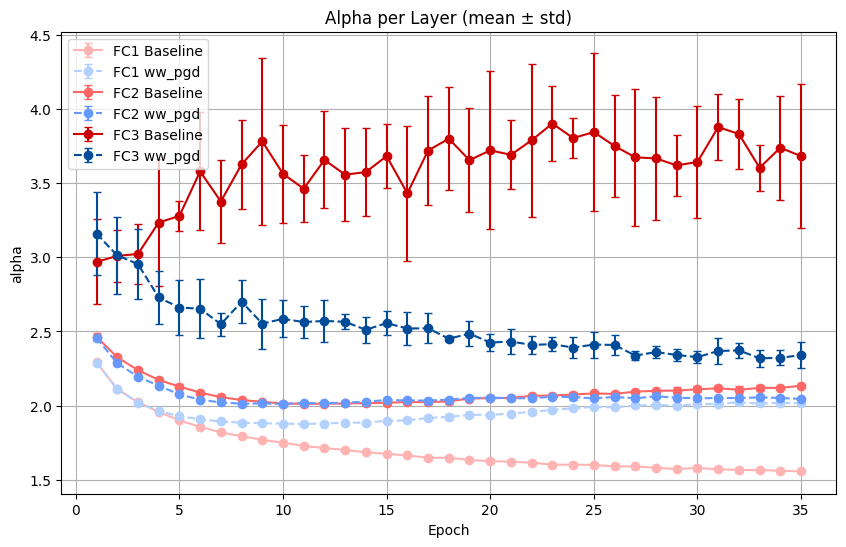

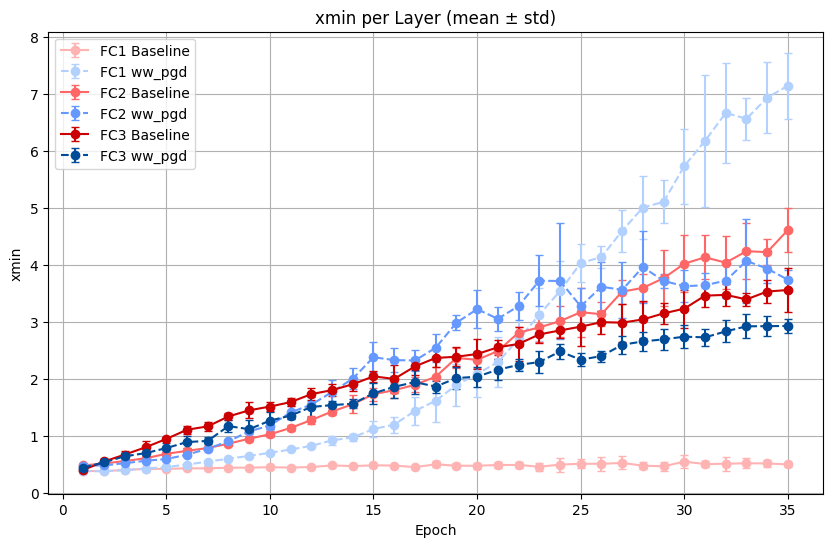

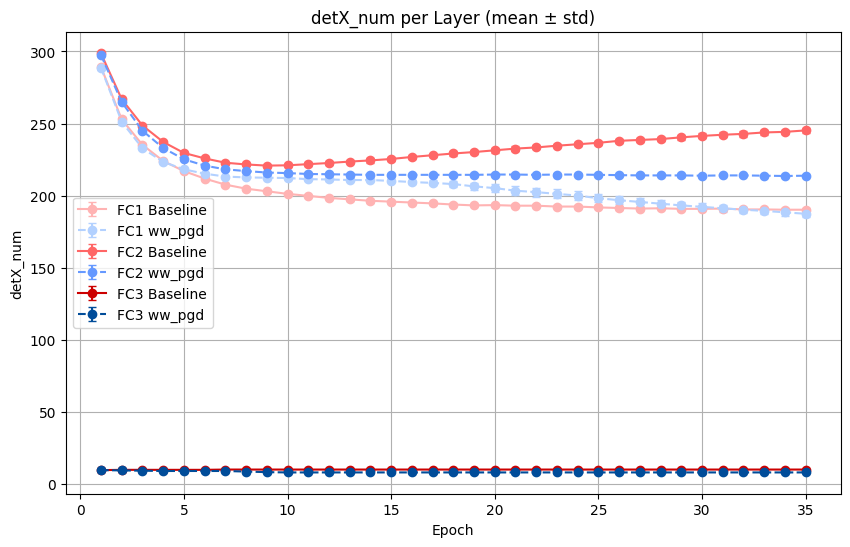

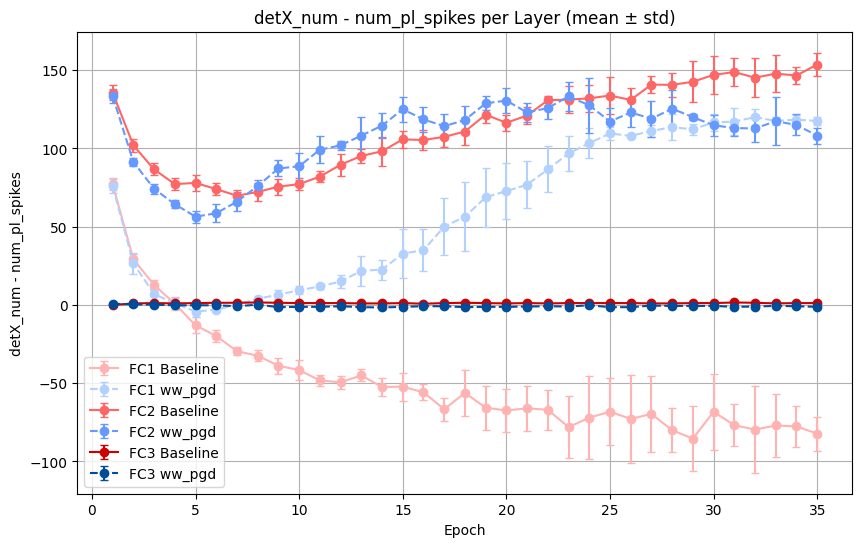

In [8]:


plot_metric_with_errorbars(alpha_base, alpha_pgd, "Alpha per Layer (mean ± std)", "alpha")
plot_metric_with_errorbars(xmin_base, xmin_pgd, "xmin per Layer (mean ± std)", "xmin")
plot_metric_with_errorbars(detx_base, detx_pgd, "detX_num per Layer (mean ± std)", "detX_num")
plot_metric_with_errorbars(trap_base, trap_pgd, "detX_num - num_pl_spikes per Layer (mean ± std)", "detX_num - num_pl_spikes")

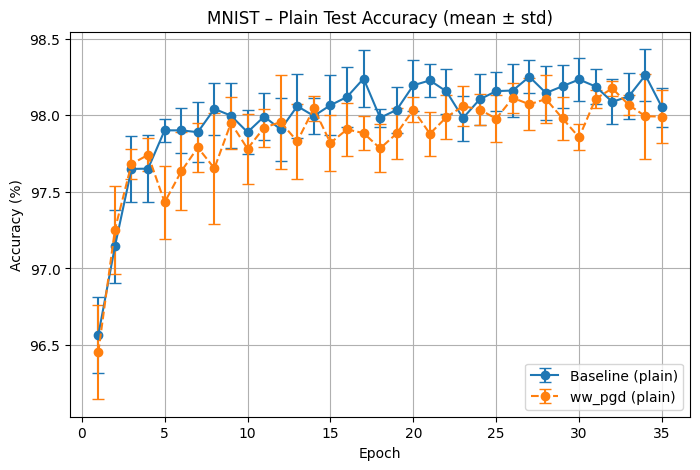

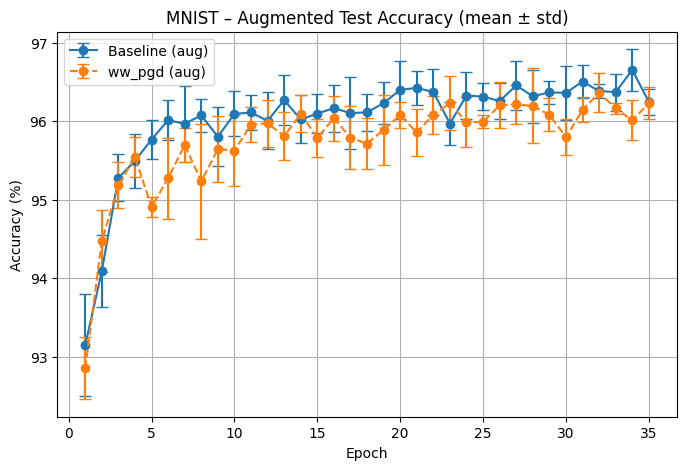


Final (epoch 35) mean ± std:
Baseline: plain=98.05% ± 0.13%, aug=96.24% ± 0.17%
ww_pgd : plain=97.99% ± 0.17%, aug=96.23% ± 0.20%


In [9]:
# -----------------------------
# Plot plain test acc
# -----------------------------
plt.figure(figsize=(8,5))
plt.errorbar(epochs, baseline_mean*100, yerr=baseline_std*100, marker="o", linestyle="-", capsize=4,
             label="Baseline (plain)")
plt.errorbar(epochs, wwpgd_mean*100, yerr=wwpgd_std*100, marker="o", linestyle="--", capsize=4,
             label="ww_pgd (plain)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("MNIST – Plain Test Accuracy (mean ± std)")
plt.grid(True)
plt.legend()
plt.show()

# -----------------------------
# Plot augmented test acc
# -----------------------------
plt.figure(figsize=(8,5))
plt.errorbar(epochs, baseline_aug_mean*100, yerr=baseline_aug_std*100, marker="o", linestyle="-", capsize=4,
             label="Baseline (aug)")
plt.errorbar(epochs, wwpgd_aug_mean*100, yerr=wwpgd_aug_std*100, marker="o", linestyle="--", capsize=4,
             label="ww_pgd (aug)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("MNIST – Augmented Test Accuracy (mean ± std)")
plt.grid(True)
plt.legend()
plt.show()

print(f"\nFinal (epoch {NUM_EPOCHS}) mean ± std:")
print(f"Baseline: plain={baseline_mean[-1]*100:.2f}% ± {baseline_std[-1]*100:.2f}%, "
      f"aug={baseline_aug_mean[-1]*100:.2f}% ± {baseline_aug_std[-1]*100:.2f}%")
print(f"ww_pgd : plain={wwpgd_mean[-1]*100:.2f}% ± {wwpgd_std[-1]*100:.2f}%, "
      f"aug={wwpgd_aug_mean[-1]*100:.2f}% ± {wwpgd_aug_std[-1]*100:.2f}%")

# ======================================================
# WW metric extraction + plots
# ======================================================

def extract_metric_paths(ww_logs_runs, num_epochs, metric_name, is_trap=False):
    """
    ww_logs_runs: list[ list[pd.DataFrame] ] per run
    returns dict[layer] -> np.array shape (N_RUNS, num_epochs)
    """
    N = len(ww_logs_runs)
    layers = ["FC1", "FC2", "FC3"]
    layer_paths = {L: np.full((N, num_epochs), np.nan) for L in layers}

    for run_idx, wwlogs in enumerate(ww_logs_runs):
        ww_all = pd.concat(wwlogs, ignore_index=True)
        name_col = "longname" if "longname" in ww_all.columns else "name"
        layer_map = {"net.1": "FC1", "net.3": "FC2", "net.5": "FC3"}
        ww_all["layer"] = ww_all[name_col].map(layer_map).fillna(ww_all[name_col])

        spikes_col = None
        if is_trap:
            if "num_pl_spikes" in ww_all.columns:
                spikes_col = "num_pl_spikes"
            elif "num_spikes" in ww_all.columns:
                spikes_col = "num_spikes"

        for L in layers:
            for e in range(num_epochs):
                df = ww_all[(ww_all["layer"] == L) & (ww_all["epoch_id"] == e)]
                if df.empty:
                    continue
                if is_trap:
                    if spikes_col is None or "detX_num" not in df.columns:
                        continue
                    layer_paths[L][run_idx, e] = float((df["detX_num"] - df[spikes_col]).mean())
                else:
                    if metric_name not in df.columns:
                        continue
                    layer_paths[L][run_idx, e] = float(df[metric_name].mean())

    return layer_paths

alpha_base = extract_metric_paths(baseline_ww_logs_runs, NUM_EPOCHS, "alpha", is_trap=False)
alpha_pgd  = extract_metric_paths(wwpgd_ww_logs_runs,   NUM_EPOCHS, "alpha", is_trap=False)

xmin_base  = extract_metric_paths(baseline_ww_logs_runs, NUM_EPOCHS, "xmin", is_trap=False)
xmin_pgd   = extract_metric_paths(wwpgd_ww_logs_runs,   NUM_EPOCHS, "xmin", is_trap=False)

detx_base  = extract_metric_paths(baseline_ww_logs_runs, NUM_EPOCHS, "detX_num", is_trap=False)
detx_pgd   = extract_metric_paths(wwpgd_ww_logs_runs,   NUM_EPOCHS, "detX_num", is_trap=False)

trap_base  = extract_metric_paths(baseline_ww_logs_runs, NUM_EPOCHS, metric_name=None, is_trap=True)
trap_pgd   = extract_metric_paths(wwpgd_ww_logs_runs,   NUM_EPOCHS, metric_name=None, is_trap=True)

baseline_colors = {"FC1":"#ffb3b3","FC2":"#ff6666","FC3":"#cc0000"}
pgd_colors      = {"FC1":"#b3d1ff","FC2":"#6699ff","FC3":"#004c99"}
layers = ["FC1","FC2","FC3"]

def plot_metric_with_errorbars(metric_base, metric_pgd, title, ylabel):
    plt.figure(figsize=(10,6))
    for L in layers:
        b = metric_base[L]
        p = metric_pgd[L]
        b_mean, b_std = np.nanmean(b, axis=0), np.nanstd(b, axis=0)
        p_mean, p_std = np.nanmean(p, axis=0), np.nanstd(p, axis=0)

        plt.errorbar(epochs, b_mean, yerr=b_std, marker="o", linestyle="-", capsize=3,
                     color=baseline_colors[L], label=f"{L} Baseline")
        plt.errorbar(epochs, p_mean, yerr=p_std, marker="o", linestyle="--", capsize=3,
                     color=pgd_colors[L], label=f"{L} ww_pgd")
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()